# Water Detection and its Classification with Sentinel-1 <img align="right" src="../Supplementary_data/DE_Africa_Logo_Stacked_RGB_small.jpg">

* **Products used:** 
[s1_rtc](),
[s2_l2a](https://explorer.digitalearth.africa/s2_l2a)

**Keywords**: :index:`data used; sentinel-1`, :index:`data used; sentinel-2`, :index:`SAR`

## Background

Over 40% of the world’s population lives within 100 km of the coastline.
However, coastal environments are constantly changing, with erosion and coastal change presenting a major challenge to valuable coastal infrastructure and important ecological habitats.
Updating data on the position of the coastline is essential for coastal managers to be able to identify and minimise the impacts of coastal change and erosion.

While coastlines can be mapped using optical data (demonstrated in the [Coastal Erosion notebook](Coastal_erosion.ipynb)), these images can be strongly affected by the weather, especially through the presence of clouds, which obscure the land and water below.
This can be a particular problem in cloudy regions or areas where wet season clouds prevent optical satellites from taking clear images for many months of the year.

Radar observations are largely unaffected by cloud cover, so can take reliable measurements of areas in any weather.
Radar data is readily available from the ESA/EC Copernicus program's Sentinel-1 satellites.
The two satellites provide all-weather observations, with a revisit time of 6 days.
By developing a process to classify the observed pixels as either water or land, it is possible to identify the shoreline from radar data.
For more information, see the [Sentinel-1 notebook](../Datasets/Sentinel_1.ipynb).

## Description

In this example, we use data from the Sentinel-1 satellites to build a classifier that can determine whether a pixel is water or land in radar data.
Specifically, this notebook uses an analysis-ready radar product known as backscatter, which describes the strength of the signal recieved by the satellite.

The notebook contains the following steps:

1. Load Sentinel-1 backscatter data for an area of interest
2. Visualise the returned data with histogram analysis for Sentinel-1 Datase
3. Applying speckle filtering to the Sentinel as a pre-processing step
4. Use threshold values to separate water and non-water areas
5. Design a classifier to distinguish land and water
5. Apply the classifier to the area of interest and interpret the results
6. Compare Sentinel-1 water detection with Sentinel-2 detections

***

## Getting started

To run this analysis, run all the cells in the notebook, starting with the "Load packages" cell. 

### Load packages
Import Python packages that are used for the analysis.

In [1]:
%matplotlib inline

import sys
import warnings 
import datacube
import numpy as np
import matplotlib.pyplot as plt

from matplotlib.gridspec import GridSpec
from scipy.ndimage import grey_dilation, grey_erosion
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance
from scipy.signal import argrelextrema
from skimage.morphology import disk
from astropy.stats import histogram 
warnings.filterwarnings("ignore")

from deafrica_tools.bandindices import calculate_indices
from deafrica_tools.datahandling import load_ard, mostcommon_crs
from deafrica_tools.plotting import display_map,rgb

### Connect to the datacube

Connect to the datacube so we can access DEA data.
The `app` parameter is a unique name for the analysis which is based on the notebook file name.

In [2]:
dc = datacube.Datacube(app="Radar_water_detection")

### Analysis parameters

The following cell sets the parameters, which define the area of interest and the length of time to conduct the analysis over.
The parameters are

* `lat`: The central latitude to analyse (e.g. `10.338`).
* `lon`: The central longitude to analyse (e.g. `-1.055`).
* `buffer`: The number of square degrees to load around the central latitude and longitude. 
For reasonable loading times, set this as `0.1` or lower.
* `time_range`: The date range to analyse (e.g. `('2021') `)

**If running the notebook for the first time**, keep the default settings below.
This will demonstrate how the analysis works and provide meaningful results.
The example covers the coast of Gomoa Fetteh, Ghana.

**To run the notebook for a different area**, make sure Sentinel-1 data is available for the chosen area using the [DEAfrica Explorer](https://explorer.digitalearth.africa).
Use the drop-down menu to check Sentinel-1 (`s1_rtc`). 

### Select location

The selected latitude and longitude will be displayed as a red box on the map below the next cell. 
This map can be used to find coordinates of other places, simply scroll and click on any point on the map to display the latitude and longitude of that location.

In [3]:
# Define the area of interest
lat = 12.62
lon = -16.29
buffer = 0.05

# Compute the bounding box for the study area
lat_range = (lat-buffer, lat+buffer)
lon_range = (lon-buffer, lon+buffer)

#timeframe
timerange = ('2020')

## View the selected location
The next cell will display the selected area on an interactive map.
Feel free to zoom in and out to get a better understanding of the area you'll be analysing.
Clicking on any point of the map will reveal the latitude and longitude coordinates of that point.

In [4]:
display_map(x=lon_range, y=lat_range)

## Load and view Sentinel-1 data

The first step in the analysis is to load Sentinel-1 backscatter data for the specified area of interest.This uses the pre-defined [load_ard](../Frequently_used_code/Using_load_ard.ipynb) utility function. When working with Sentinel-2, the function will also combine and sort images from both Sentinel-1A and Sentinel-1B.

**Please be patient**.
The data may take a few minutes to load and progress will be indicated by text output.
The load is complete when the cell status goes from `[*]` to `[number]`.

In [5]:
# Load the Sentinel-1 data
S1 = load_ard(dc=dc,
              products=["s1_rtc"],
              measurements=['vv', 'vh'],
              y=lat_range,
              x=lon_range,
              time=timerange,
              group_by="solar_day",
              dtype='native'
             )

Using pixel quality parameters for Sentinel 1
Finding datasets
    s1_rtc
Applying pixel quality/cloud mask
Loading 31 time steps


**Once the load is complete**, examine the data by printing it in the next cell.
The `Dimensions` argument reveals the number of time steps in the data set, as well as the number of pixels in the `x` (longitude) and `y` (latitude) dimensions.

In [6]:
S1

<xarray.Dataset>
Dimensions:      (latitude: 500, longitude: 500, time: 31)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T19:17:46.582116 ... 2020-12...
  * latitude     (latitude) float64 12.67 12.67 12.67 ... 12.57 12.57 12.57
  * longitude    (longitude) float64 -16.34 -16.34 -16.34 ... -16.24 -16.24
    spatial_ref  int32 4326
Data variables:
    vv           (time, latitude, longitude) float32 0.0435871 ... 0.18705945
    vh           (time, latitude, longitude) float32 0.004237416 ... 0.0157548
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### Visualise S1 in its two polarisation bands and RGB color composite 

To see how S1 corresponds with a standard image, we can plot the radar backscatter in each polarisation  side-by-side with an RGB plot of the study area:

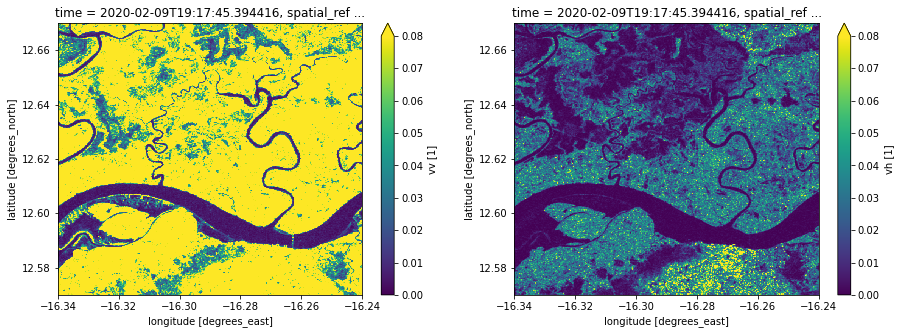

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
S1.isel(time=3).vv.plot(vmin=0,vmax=0.08, ax = ax[0])
S1.isel(time=3).vh.plot(vmin=0,vmax=0.08, ax = ax[1]);

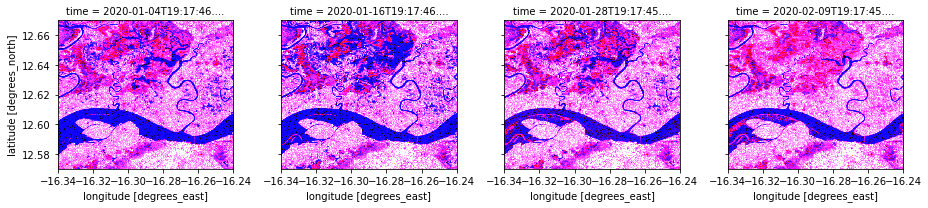

In [8]:
#Selecting a few images from the loaded S1 to visualise 
timesteps = [0,1,2,3]
# VH/VV is a potentially useful third feature after VV and VH 
S1['vh/vv'] = S1.vh/S1.vv
#plotting an RGB image for selected timesteps 
S1[['vv','vh','vh/vv']].to_array().isel(time=timesteps).plot.imshow(col='time',col_wrap=4,vmin=0,vmax=0.05);

### Zooming on a specific Area 

In [9]:
#Setting up the box 
zoomed_xmin = -16.29
zoomed_xmax = -16.25
zoomed_ymax = 12.66
zoomed_ymin = 12.61
#Extracting the zoomed area from the loaded S1 dataset 
S1_subset = S1.sel(longitude = slice(zoomed_xmin, zoomed_xmax), latitude = slice(zoomed_ymax, zoomed_ymin))

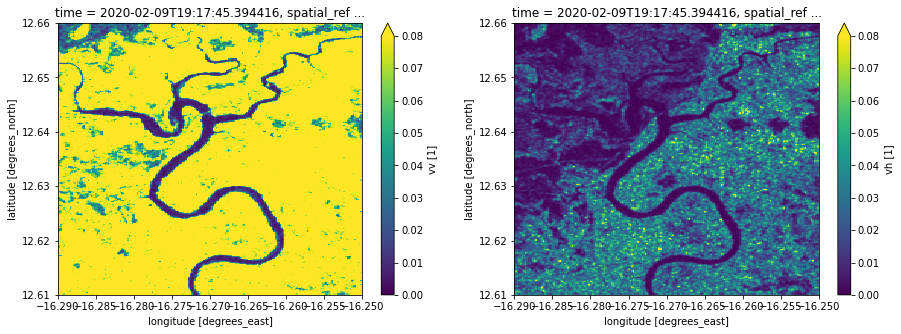

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
S1_subset.isel(time=3).vv.plot(vmin=0,vmax=0.08, ax = ax[0])
S1_subset.isel(time=3).vh.plot(vmin=0,vmax=0.08, ax = ax[1]);

## Histogram Analysis for Sentinel-1 Dataset 

Histrograms below show bimodal distributions where low backscatter is measured over water. Here, it will be demonstrated on how this can be used to map water.

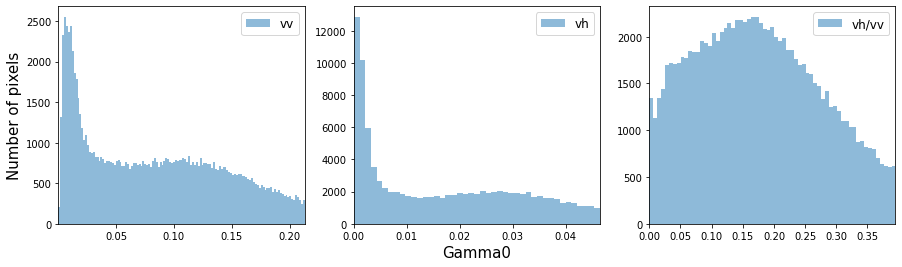

In [11]:
f, axes =plt.subplots(1, 3, figsize=(15,4))

for i, band in enumerate(['vv','vh','vh/vv']):

    test = S1[band].values.ravel()
    test = test[~np.isnan(test)]
    test = test[test < np.percentile(test, 90)]
    h, b = histogram(np.random.choice(test, 100000), bins='knuth')
    axes[i].bar(b[:-1],h,width=b[1]-b[0], align='edge', alpha=0.5,label=band);
    axes[i].set_xlim((b[0], b[-1]));
    axes[i].legend(fontsize=12);

axes[1].set_xlabel('Gamma0',size=15);
axes[0].set_ylabel('Number of pixels',size=15);

As histograms represent, VV gives best separation between land and water in general. 

## Apply Speckle Filtering to the Data 

Speckle filtering calculates local area statistics, either in a box shape such as 7 x 7 or through an adaptive approach that estimates areas of local homogeneity. This introduces a degree of spatial averaging. Hence the spatial resolution is reduced by a degree of local smoothing. This type of filtering will remove/reduce negative and extremely high backscatter values.

In [12]:
#defining a function to apply lee filtering on S1 image 
def lee_filter(da, size):
    """
    Apply lee filter of specified window size.
    Adapted from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python

    Option to fill negative pixel with grey_dilation
    """
    img = da.values
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    
    return img_output

In [13]:
#defining a function to apply denoising by making use of the lee filter 
def denoise(ds, verbose = False, bands = None, fill_negative = True, remove_high = False):
    """
    Apply lee filter to a S1 dataset loaded from datacube.
    Keep nodata pixels as lee filter implemnation doesn't consider nan
    """
    if not bands: bands = list(ds.data_vars)    
    # save the nodata mask
    zero_mask = (ds==0).to_array().any(axis=0)
    nan_mask = (np.isnan(ds)).to_array().any(axis=0)
    nodata_mask = zero_mask | nan_mask
    ds = ds.where(~nodata_mask, 0)
    smoothed = ds[bands[0]].groupby('time').apply(lee_filter, size=7).to_dataset(name=bands[0])
    for band in bands[1:]: smoothed[band] = ds[band].groupby('time').apply(lee_filter, size=7)
        
    if fill_negative:
        # reduce impact of negative pixels
        for band in bands:
            dilated = smoothed[band].groupby('time').apply(grey_dilation, footprint=disk(3))
            smoothed[band] = smoothed[band].where(smoothed[band] > 0, dilated)

    if verbose:
        for band in bands: print("# of negative pixels in %s:"%band, (smoothed[band]<0).sum().values)

    if remove_high:
        # reduce extreme outliers 
        for band in bands:
            eroded = smoothed[band].groupby('time').apply(grey_erosion, size=(3,3))
            smoothed[band] = smoothed[band].where(smoothed[band] < eroded.max(), eroded)

    return smoothed.where(~nodata_mask)


In [14]:
S1_filtered= denoise(S1)

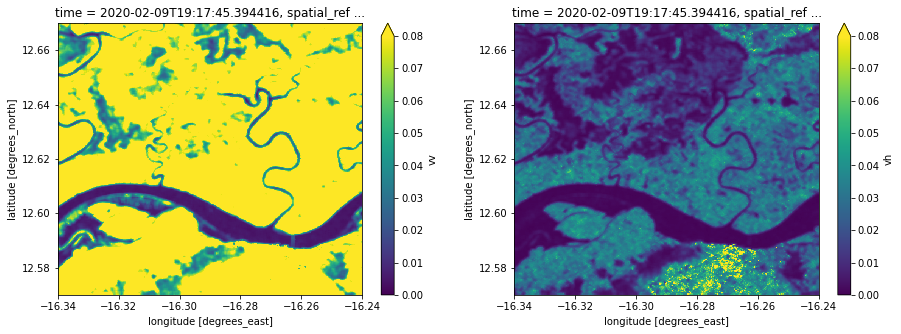

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
S1_filtered.isel(time=3).vv.plot(vmin=0,vmax=0.08, ax = ax[0])
S1_filtered.isel(time=3).vh.plot(vmin=0,vmax=0.08, ax = ax[1]);

In [16]:
# Applying mean filtering 
smoothed_mean = S1.rolling(longitude=7).mean().rolling(latitude=7).mean()

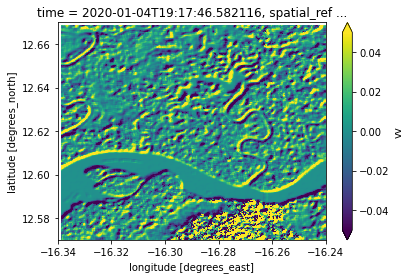

In [17]:
# visible difference on edge of features and for narrow features
(smoothed_mean.isel(time=0).vv - S1_filtered.isel(time=0).vv).plot(vmin=-0.05, vmax=0.05);

## Use threshold values to separate water and non-water areas 

In [18]:
#defining a function to find the optimal minimum 
def find_optimal_minimum(hist, hist_x, min_valid=0.001, max_valid=0.03, min_contrast=1.2, min_perc= 0.01, 
                         verbose=False):
    minima= hist_x[argrelextrema(hist, np.less, order=1)]
    maxima= hist_x[argrelextrema(hist, np.greater, order=1)]
    # no minima or maxima found
    if len(minima)==0 or len(maxima)==0: 
        if verbose: print('no minima or maxima')
        return None
    # minima not in approprite range
    if minima.max() < min_valid or minima.min() > max_valid: 
        if verbose: print('minima outside valid range')
        return None
    minima=minima[minima>=min_valid]
    minima=minima[minima<=max_valid]
    # find minimum with largest contrast
    contrast=0
    best_m=None
    hist_maxima=hist[argrelextrema(hist, np.greater, order= 1)]
    for m in minima:
        # has to have a maximum on lower side
        lower_peaks=hist_maxima[maxima<m]
        if len(lower_peaks)==0: continue
        # has to have more than min_perc below threshold
        # note the histograms don't extend full range of values, so 0.1 means much less than 10% overall
        # this can potentially be constrained from minimum extent from wofs
        if hist[:np.where(hist_x==m)[0][0]+1].sum()/hist.sum()<min_perc: continue
        low=hist[np.where(hist_x==m)[0]][0]    
        this_contrast=lower_peaks.max()/low
        if this_contrast>contrast:
            contrast=this_contrast
            best_m=m
    if best_m is None or contrast<min_contrast: 
        if verbose: print('Minimum percent or minimum contrast is not met.')
        return None
    return hist_x[np.where(hist_x==best_m)[0]+1][0]  # right boundary

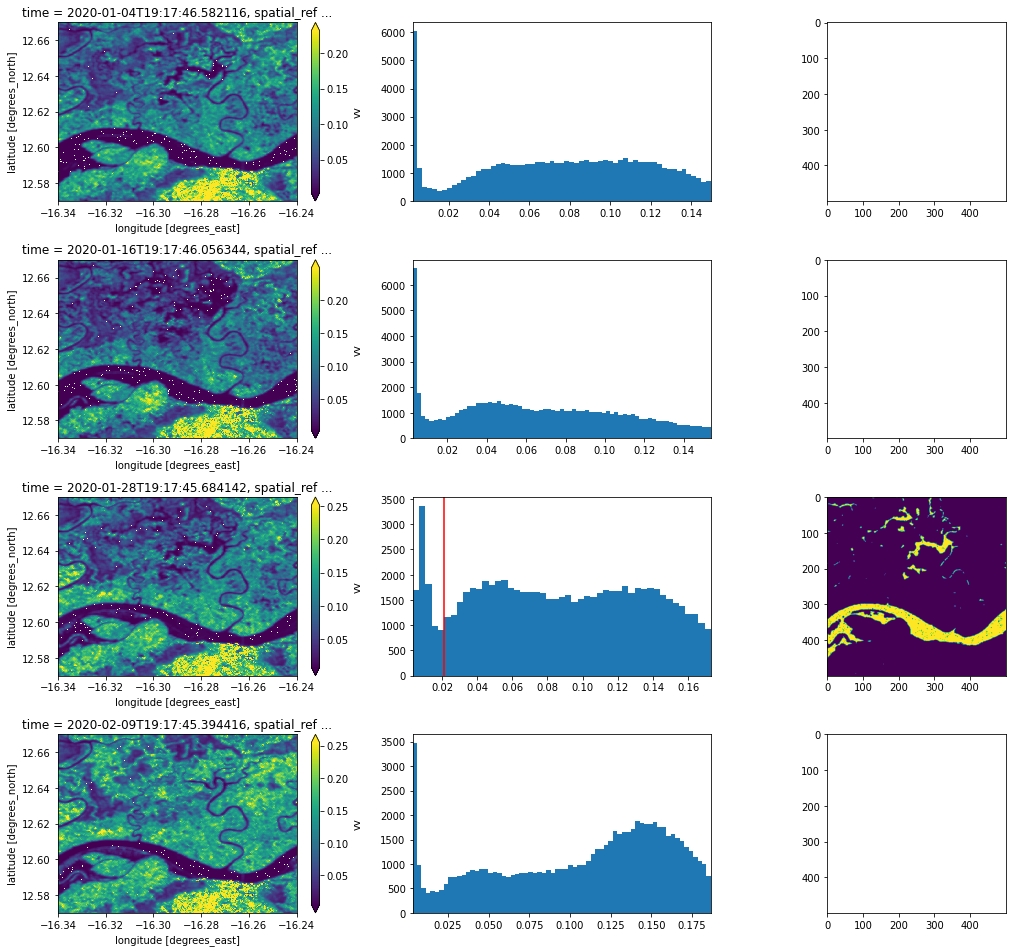

In [19]:
#ntime = len(S1_filtered.time.values)
ntime = 4
ncol = 3
nrow = int(np.ceil(ntime*3./ncol))

f=plt.figure(figsize=(15,10/ncol*nrow))
gs=GridSpec(nrow, ncol)

band = 'vv'
water = np.zeros_like(S1_filtered[band])

for i in range(ntime):
    ax = f.add_subplot(gs[i*3])
    S1_filtered[band].isel(time=i).plot.imshow(ax= ax, robust=True)
    
    ax = f.add_subplot(gs[i*3+1])
    arr = S1_filtered[band].isel(time=i).values.ravel()
    arr = arr[~np.isnan(arr)]
    # shorten the array to speed up
    arr = arr[arr < np.percentile(arr, 90)]
    hist, hist_x = histogram(np.random.choice(arr, int(len(arr)/3)), bins='knuth')
    ax.bar(hist_x[:-1],hist,width=hist_x[1]-hist_x[0], align='edge')
    ax.set_xlim((hist_x[0],hist_x[-1]))
    
    minima= find_optimal_minimum(hist, hist_x, min_valid=0.001, max_valid=0.02, min_contrast=1.2, min_perc= 0.01)

    if minima is not None:
        water[i,:,:]=S1_filtered[band].isel(time=i) <= minima
        ax.axvline(minima, color='r')
    else: # failed to separate water and non-water, but can't say for sure there's no water
        water[i,:,:] = np.nan
    
    ax = f.add_subplot(gs[i*3+2])
    ax.imshow(water[i,::1,::1]) # orientation consistent with xarray plot

f.tight_layout()

Given that the distinction between the `land` and `water` pixel value distributions is strongest in the *VV* band, we'll base our classifier on this distribution.
To separate them, we can choose a threshold: pixels with values below the threshold are water, and pixels with values above the threshold are not water (land).

There are a number of ways to determine the threshold; one is to estimate it by looking at the *VV* histogram.
From this, we might guess that $\text{threshold} = 0.03$ is a reasonable value.

## Build and apply the classifier 

Now that we know the threshold, we can write a function to only return the pixels that are classified as water. The basic steps that the function will perform are:

1. Find all pixels that have filtered values lower than the threshold; these are the `water` pixels.
2. Return a data set containing the `water` pixels.

These steps correspond to the actions taken in the function below.

In [20]:
def S1_water_classifier(ds, threshold=0.03):
    filtered = ds.vv.groupby("time").apply(lee_filter, size=7)
    water_data_array = filtered < threshold
    return water_data_array.to_dataset(name="s1_water")

In [21]:
S1['water'] = S1_water_classifier(S1).s1_water

Now that we have defined the classifier function, we can apply it to the data. After running the classifier, we will able to view the classified data product by running `print(S1.water)`.

In [22]:
S1

<xarray.Dataset>
Dimensions:      (latitude: 500, longitude: 500, time: 31)
Coordinates:
  * time         (time) datetime64[ns] 2020-01-04T19:17:46.582116 ... 2020-12...
  * latitude     (latitude) float64 12.67 12.67 12.67 ... 12.57 12.57 12.57
  * longitude    (longitude) float64 -16.34 -16.34 -16.34 ... -16.24 -16.24
    spatial_ref  int32 4326
Data variables:
    vv           (time, latitude, longitude) float32 0.0435871 ... 0.18705945
    vh           (time, latitude, longitude) float32 0.004237416 ... 0.0157548
    vh/vv        (time, latitude, longitude) float32 0.09721721 ... 0.084223494
    water        (time, latitude, longitude) bool False False ... False False
Attributes:
    crs:           EPSG:4326
    grid_mapping:  spatial_ref

### Assessment with mean

We can now view the image with our classification.
The classifier returns either `True` or `False` for each pixel.
To detect the bounaries of water features, we want to check which pixels are always water and which are always land.
Conveniently, Python encodes `True = 1` and `False = 0`.

If we plot the average classified pixel value, pixels that are always water will have an average value of `1` and pixels that are always land will have an average of `0`.
Pixels that are sometimes water and sometimes land will have an average between these values. In this case study, these pixels are associated with wetland areas. 

The following cell plots the average classified pixel value over time.

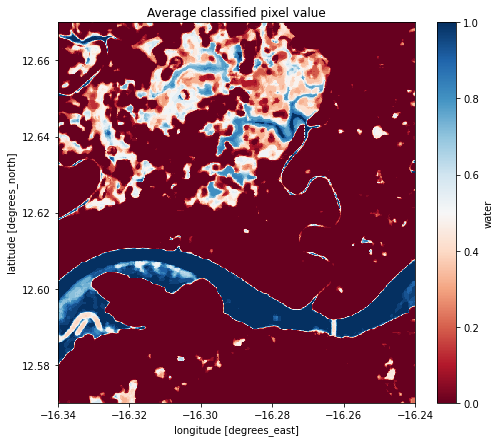

In [23]:
# Plot the mean of each classified pixel value
plt.figure(figsize=(8, 7))
S1.water.mean(dim='time').plot(cmap="RdBu")
plt.title("Average classified pixel value");

You can see that the selected threshold has done a good job of separating the water pixels (in blue) and land pixels (in red) as well as ephemeral water features in between. 

You should be able to see that the shoreline takes on a mix of values between `0` and `1`, highlighting pixels that are sometimes land and sometimes water.
This is likely to due the effect of rising and falling tides, with some radar observations being captured at low tide, and others at high tide.

Given that we've identified the shoreline as the pixels that are classified sometimes as land and sometimes as water, we can also see if the standard deviation of each pixel in time is a reasonable way to determine if a pixel is shoreline or not.

Similar to how we calculated and plotted the mean above, you can calculate and plot the standard deviation by using the `std` function in place of the `mean` function.

If you'd like to see the results using a different colour-scheme, you can also try substituting `cmap="Greys"` or `cmap="Blues"` in place of `cmap="viridis"`.


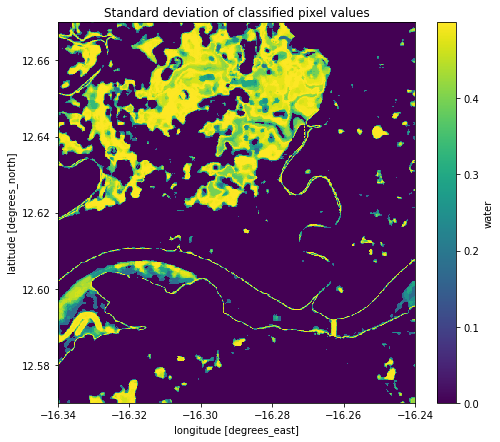

In [24]:
plt.figure(figsize=(8, 7))
S1.water.std(dim="time").plot(cmap="viridis")
plt.title("Standard deviation of classified pixel values");

The standard deviation we calculated above gives us an idea of how variable a pixel has been over the entire period of time that we looked at. From the image above, you should be able to see that the land and water pixels almost always have a standard deviation of `0`, meaning they didn't change over the time we sampled.Areas along the coastline however have a higher standard deviation, indicating that they change frequently between water and non-water (potentially due to the rise and fall of the tide). 
With further investigation, you could potentially turn this statistic into a new classifier to extract shoreline pixels.

An important thing to recognise is that the standard deviation might not be able to detect the difference between noise, tides and ongoing change, since a pixel that frequently alternates between land and water (noise) could have the same standard deviation as a pixel that is land for some time, then becomes water for the remaining time (ongoing change or tides).

In [25]:
#Sentinel-1 water detection frequency every 2Months
freq_s1_water = S1.water.resample(time='2MS').mean(dim='time')

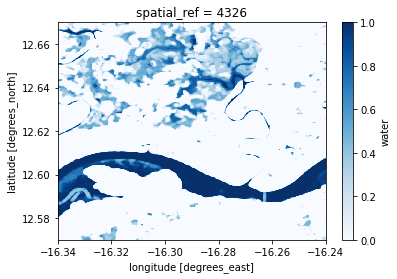

In [26]:
#Plotting the detection frequency  
s1_water = S1.water.mean(dim='time')
s1_water.plot(cmap='Blues');

## Comparison with Sentinel-2 Detections 
In the following cells, we use the denoised dataset to caculate water detection frequecy for each pixel in the area and compare to optical detections.

In [27]:
# Load the Sentinel-2 data
S2 = load_ard(dc=dc,
              products=["s2_l2a"],
              measurements=['blue', 'green', 'red','nir', 'swir_1', 'swir_2'],
              resolution = (-10,10),
              y=lat_range,
              x=lon_range,
              min_gooddata=0.5,
              time=timerange,
              output_crs = "EPSG:6933",
              group_by="solar_day",
             )

Using pixel quality parameters for Sentinel 2
Finding datasets
    s2_l2a
Counting good quality pixels for each time step
Filtering to 87 out of 145 time steps with at least 50.0% good quality pixels
Applying pixel quality/cloud mask
Loading 87 time steps


In [28]:
#Calculating water indices for Sentinel-2
S2_water_index = calculate_indices(S2,index=['MNDWI', 'TCW' ,'WI'], normalise=True, collection='s2', drop=True).compute()

Dropping bands ['blue', 'green', 'red', 'nir', 'swir_1', 'swir_2']


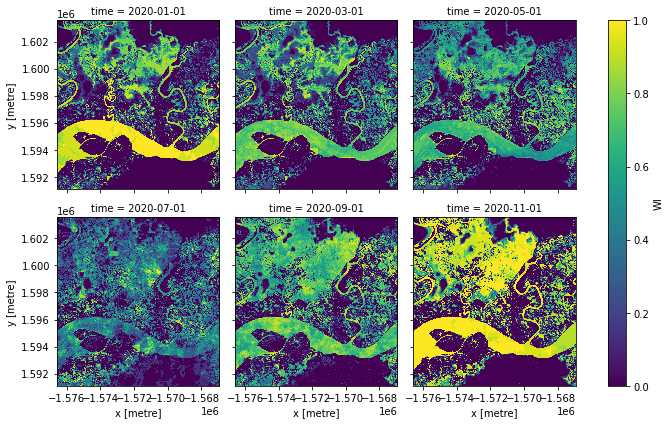

In [29]:
# frequency calculated using WI,the result is very senstive to the threshold
freq_s2_wi = (S2_water_index.WI > 0.65).resample(time='2MS').mean(dim='time').compute()
# water frequency plotting 
freq_s2_wi.plot.imshow(robust=True, col='time', col_wrap=3);

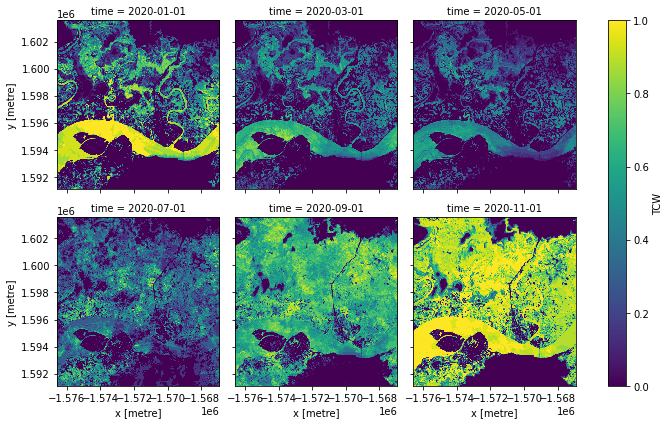

In [30]:
# frequency calculated using TCW, the result is very senstive to the threshold
# I think the recommended threhold is 0.01, which doesn't give much water in this case
freq_s2_tcw = (S2_water_index .TCW>-0.01).resample(time='2MS').mean(dim='time').compute()
# water frequency plotting
freq_s2_tcw.plot.imshow(robust=True, col='time', col_wrap=3);

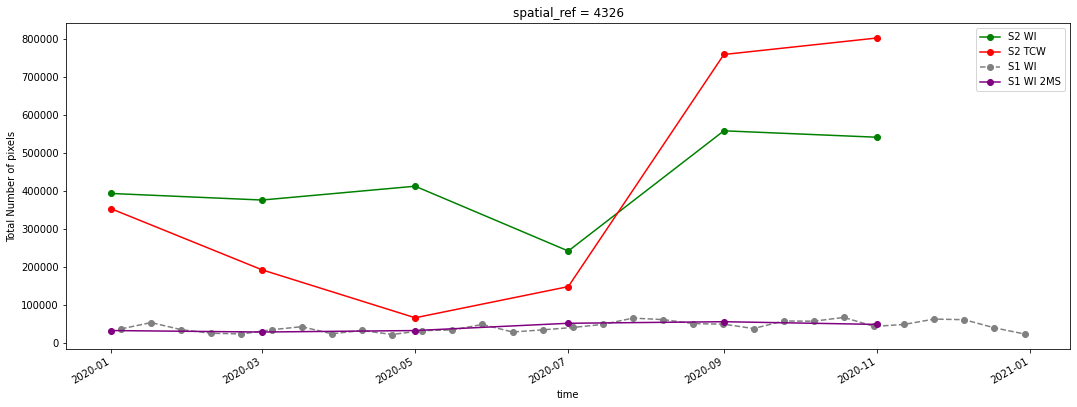

In [31]:
WI = (freq_s2_wi>0.5).sum(['x','y'])
TCW = (freq_s2_tcw>0.5).sum(['x','y'])
S1_WI = (S1.water).sum(['longitude','latitude'])
S1_WI_sampled = (freq_s1_water>0.5).sum(['longitude','latitude'])

fig, ax = plt.subplots(figsize=(18, 6))

WI.plot.line('b-o', ax=ax, color='green', label='S2 WI')
ax.set_title('WI time series compared to TCW \n', fontsize="15", color="black")
TCW.plot.line('b-o', ax=ax, color='red', label='S2 TCW')
S1_WI.plot.line('b-o', ax=ax, color='grey', label='S1 WI ',linestyle='dashed');
S1_WI_sampled.plot.line('b-o', ax=ax, color='purple', label='S1 WI 2MS')
plt.ylabel('Total Number of pixels')
plt.legend();


All dataset show peak water extent between July and September 2020. Comparing the frequency of water features accurance that was detected by Sentinel-2 compared to Sentinel-1 shows that the temporal coverage of the Sentinel-1 imagery is significantly higher than Sentinel-2 and potentially can be used for long-term wetland dynamics in the region; however, Sentinel-2 is more useful for defining and separating the wet and dry season in this region. It is demonstrated that in the above region, following July 2020, there was a significant increase in the number of pixels that are classified as water. 

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Africa data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/digitalearthafrica/deafrica-sandbox-notebooks).

**Compatible datacube version:**

In [32]:
print(datacube.__version__)

1.8.4.dev63+g6ee0462c


**Last Tested:**

In [33]:
from datetime import datetime
datetime.today().strftime('%Y-%m-%d')

'2021-05-25'